https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb

# Understanding the Difference Between Embedding Layers and Linear Layers
- Embedding layers in PyTorch accomplish the same as linear layers that perform matrix multiplications; the reason we use embedding layers is computational efficiency
- We will take a look at this relationship step by step using code examples in PyTorch

In [1]:
import torch
print("Pytorch Version:",torch.__version__)

Pytorch Version: 2.7.0


### Using nn.Embedding

In [2]:
# suppose we have 3 trainig examples, these three training examples represent token ids in LLM context
idx = torch.tensor([2,3,1])

# number of rows in the embedding matrix could be determined by largest token id, in our case we have 3, hen we want 4 possible rows,
# for token ids = 0,1,2,3
# so number of rows in the embedding = largest token id +1
num_idx = max(idx) + 1
# the desired embedding dimension is a hyperparameter
out_dim = 5

- lets implement a simple embedding layer :

In [3]:
# for reproduceability we will use the random seed, since the weights in the embedding 
# are initialized with the small random values
torch.manual_seed(123)
embedding = torch.nn.Embedding(num_idx,out_dim) # num_idx = number of rows, # out_dim = number of columns in the matrix

In [4]:
# we take a look at embedding weights
embedding.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)

- we can use the embedding layer to extract the vector reprsentation of token id = 1

In [5]:
embedding(torch.tensor([1]))

tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

In [6]:
# similarly for token id = 2
embedding(torch.tensor([2]))

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315]],
       grad_fn=<EmbeddingBackward0>)

- Now we can convert all training example,


In [7]:
idx = torch.tensor([2,3,1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

### Using nn.Linear

- Now, we will demonstrate that the embedding layer above accomplishes exactly the same as nn.Linear layer on a one-hot encoded representation in PyTorch
- First, let's convert the token IDs into a one-hot representation:

In [8]:
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

Next, we initialize a Linear layer, which carries out a matrix multiplication 

In [9]:
print("num_idx:\n",num_idx)
print("out_dim:\n",out_dim)

num_idx:
 tensor(4)
out_dim:
 5


In [10]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx,out_dim, bias=False). 
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

Note that the linear layer in PyTorch is also initialized with small random weights; to directly compare it to the Embedding layer above, we have to use the same small random weights, which is why we reassign them here:

In [12]:
linear.weight = torch.nn.Parameter(embedding.weight.T)
linear.weight

Parameter containing:
tensor([[ 0.3374,  1.3010,  0.6957, -2.8400],
        [-0.1778,  1.2753, -1.8061, -0.7849],
        [-0.3035, -0.2010, -1.1589, -1.4096],
        [-0.5880, -0.1606,  0.3255, -0.4076],
        [ 1.5810, -0.4015, -0.6315,  0.7953]], requires_grad=True)

In [13]:
linear(onehot.float())

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]], grad_fn=<MmBackward0>)

In [14]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

- What happens under the hood is the following computation for the first training example's token ID:
  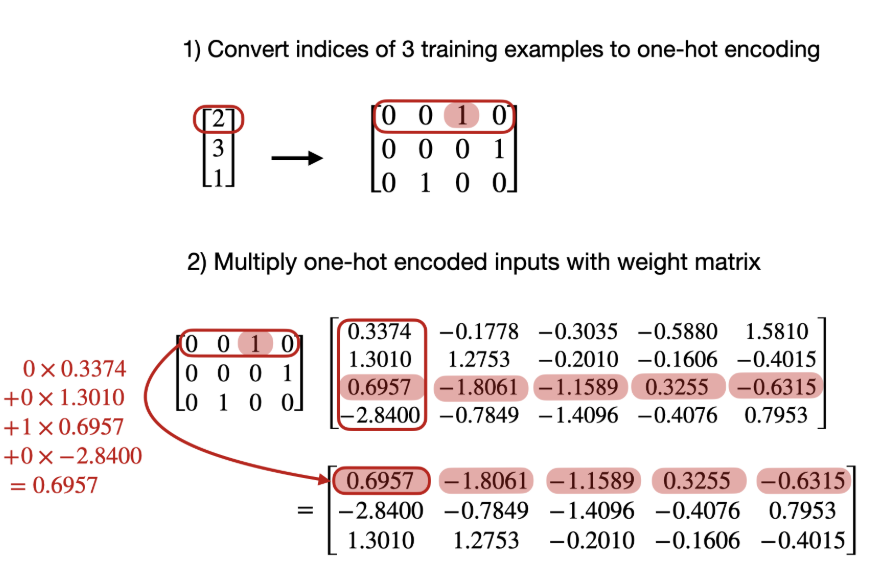
- And for the second training example's token ID:
  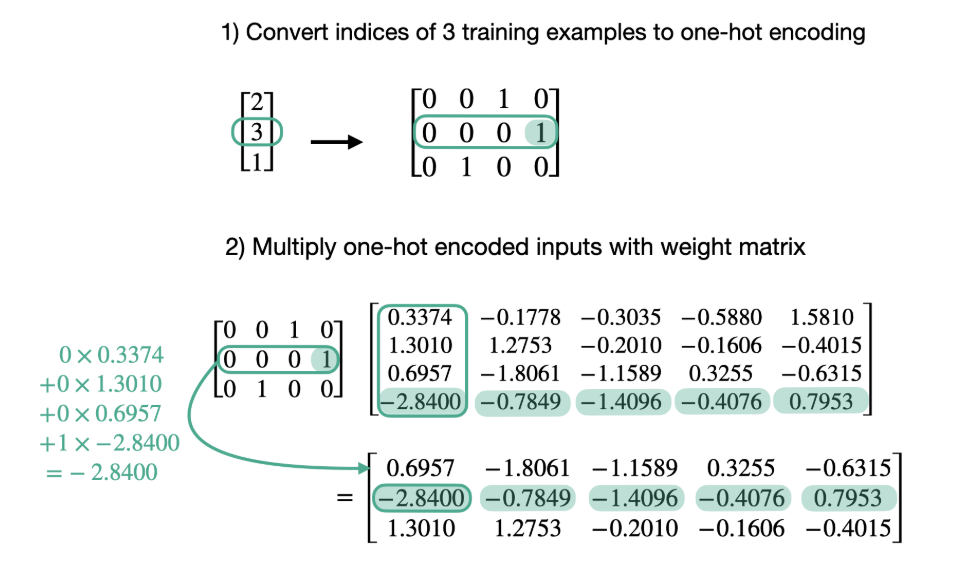

Since all but one index in each one-hot encoded row are 0 (by design), this matrix multiplication is essentially the same as a look-up of the one-hot elements
This use of the matrix multiplication on one-hot encodings is equivalent to the embedding layer look-up but can be inefficient if we work with large embedding matrices, because there are a lot of wasteful multiplications by zero